In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
import pickle

<h1> 5. Assignments </h1>

<ol>
    <li> Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) </li>
    <li> Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  </li>
    <li> Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)</li>
</ol>

 ### Modeling with less data points (0.1M data points) and more weight to title and 500 tags only. 

In [1]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [ ]:
#Taking only 0.1 Million entries to a dataframe due to computational constrain.
con = sqlite3.connect('Titlemoreweight.db')
processed = pd.read_sql_query("""SELECT * FROM QuestionsProcessed""", con)

In [5]:
processed.head()

,question,code,tags,words_pre,words_post,is_code
0,dynam datagrid bind silverlight dynam datagrid...,['MyClass myInstance = new MyClass();\ndataGri...,c# silverlight data-binding,904,252,1
1,dynam datagrid bind silverlight dynam datagrid...,['MyClass myInstance = new MyClass();\ndataGri...,c# silverlight data-binding columns,904,252,1
2,java.lang.noclassdeffounderror javax servlet j...,"['&lt;%@taglib prefix=""c"" uri=""http://java.sun...",jsp jstl,745,463,1
3,java.sql.sqlexcept microsoft odbc driver manag...,"['try {\n Class.forName(""sun.jdbc.odbc.Jdbc...",java jdbc,1056,249,1
4,better way updat feed fb php sdk better way up...,"['$data = array(""message"" =&gt; ""Hello World!""...",facebook api facebook-php-sdk,607,233,1


In [ ]:
preprocessed_data=pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed LIMIT 100000""", con)
preprocessed_data.head()

In [7]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 100000
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [8]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [9]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

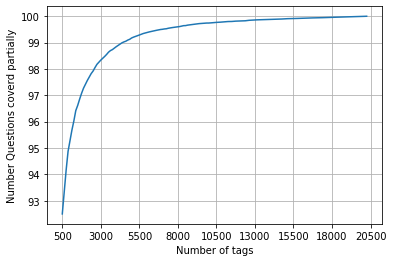

with  5500 tags we are covering  99.481 % of questions
with  500 tags we are covering  92.5 % of questions


In [10]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [11]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 7500 out of  100000


In [12]:
# Train Test Split
train_datasize=80000
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 80000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [13]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 500)
Number of data points in test data : (20000, 500)


## 1. Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR)


### Featurizing data with BOW vectorizer 
NOTE: Limiting Maximum features to 100k because of coumputational strain

In [15]:
# Bag OF Word of n_gram_range=(1,4)
start = datetime.now()
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(),  ngram_range=(1,4),max_features=100000)
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:04.732305


In [16]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 100000) Y : (80000, 500)
Dimensions of test data X: (20000, 100000) Y: (20000, 500)


Note :
    Taking only 100000 datapoint and 100k maximum feature because of computational constrain

In [26]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1', n_jobs=-1),)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.17445
Hamming loss  0.003358
Micro-average quality numbers
Precision: 0.5830, Recall: 0.3649, F1-measure: 0.4489
Macro-average quality numbers
Precision: 0.4208, Recall: 0.2851, F1-measure: 0.3288
              precision    recall  f1-score   support

           0       0.69      0.39      0.50       820
           1       0.53      0.32      0.40      1931
           2       0.37      0.18      0.24       544
           3       0.51      0.21      0.29       222
           4       0.70      0.51      0.59      1311
           5       0.75      0.51      0.61      1014
           6       0.66      0.44      0.53      1374
           7       0.73      0.59      0.65       702
           8       0.90      0.63      0.74      1424
           9       0.75      0.64      0.69      1037
          10       0.72      0.57      0.64       797
          11       0.55      0.38      0.45       156
          12       0.57      0.36      0.44        36
          13       0.67      0.41

## 2. Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  


In [ ]:
# Train
from sklearn.model_selection import GridSearchCV
start = datetime.now()

param={"estimator__C":[0.0001,0.001,0.01,0.1,1,10,100]} # When you use nested estimators with grid search you can scope the parameters with __ as a separator

lr_ovr = OneVsRestClassifier(LogisticRegression(C=1.0,penalty='l1', n_jobs=-1),)
classifier_2=GridSearchCV(estimator=lr_ovr, param_grid=param ,scoring="f1_micro", return_train_score=True)
classifier_2.fit(x_train_multilabel, y_train)

print("Time taken to run this cell :", datetime.now() - start)

In [3]:
import pickle
"""file=open("gridsearch.pkl",'wb')
pickle.dump(classifier_2,file)
file.close()
"""
file=open("gridsearch.pkl",'rb')
gridsearch=pickle.load(file)

In [4]:
# CV Score
gridsearch.cv_results_

{'mean_fit_time': array([ 341.93791715,  363.59180037,  423.69569087,  678.68307408,
         935.50097712, 1013.79868793, 1081.59573984]),
 'std_fit_time': array([96.9851387 , 52.27677961, 19.59633154, 50.61290431, 42.16038204,
        37.69262534, 33.27912207]),
 'mean_score_time': array([3.76426148, 3.77001405, 3.71273176, 3.73366205, 3.7477115 ,
        3.70152036, 3.7257247 ]),
 'std_score_time': array([0.200987  , 0.23564235, 0.22734413, 0.21825075, 0.23177296,
        0.18633856, 0.21896373]),
 'param_estimator__C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__C': 0.0001},
  {'estimator__C': 0.001},
  {'estimator__C': 0.01},
  {'estimator__C': 0.1},
  {'estimator__C': 1},
  {'estimator__C': 10},
  {'estimator__C': 100}],
 'split0_test_score': array([2.01804129e-04, 8.63213305e-02, 2.61891013e-01, 3.86039087e-01,
        4

In [7]:
# best score and hyperparameter
print("Best Parameter:",gridsearch.best_params_)
print("Best F1 micro Score:",gridsearch.best_score_)

Best Parameter: {'estimator__C': 1}
Best F1 micro Score: 0.45869086799788344


In [38]:
# Test
# Prediction using best score LOgistic regression
predictions_2 = gridsearch.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))

precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))


Accuracy : 0.1743
Hamming loss  0.0033586
Micro-average quality numbers
Precision: 0.5828, Recall: 0.3650, F1-measure: 0.4488
Macro-average quality numbers
Precision: 0.4206, Recall: 0.2851, F1-measure: 0.3288
              precision    recall  f1-score   support

           0       0.69      0.39      0.50       820
           1       0.53      0.32      0.40      1931
           2       0.37      0.18      0.24       544
           3       0.51      0.21      0.29       222
           4       0.70      0.51      0.59      1311
           5       0.75      0.52      0.61      1014
           6       0.66      0.44      0.53      1374
           7       0.73      0.59      0.65       702
           8       0.90      0.63      0.74      1424
           9       0.75      0.64      0.69      1037
          10       0.72      0.57      0.64       797
          11       0.55      0.38      0.45       156
          12       0.57      0.36      0.44        36
          13       0.67      0.41

### 3. Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge) USING GridSearch</li>

In [17]:
# Train
from sklearn.model_selection import GridSearchCV
start = datetime.now()

param={"estimator__alpha":[0.0001,0.001,0.01,0.1,1,10,100]} # When you use nested estimators with grid search you can scope the parameters with __ as a separator

lr_ovr = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1',n_jobs=-1),)
classifier_2=GridSearchCV(estimator=lr_ovr, param_grid=param ,scoring="f1_micro", return_train_score=True)
classifier_2.fit(x_train_multilabel, y_train)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 2:08:38.593076


In [19]:
# Saving Result
import pickle
"""file=open("gridsearch_svm.pkl",'wb')
pickle.dump(classifier_2,file)
file.close()
"""
file=open("gridsearch_svm.pkl",'rb')
gridsearch_svm=pickle.load(file)

In [20]:
# Test
# Prediction using best score SVM
predictions_2 = gridsearch_svm.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))

precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))


Accuracy : 0.13035
Hamming loss  0.0036607
Micro-average quality numbers
Precision: 0.5228, Recall: 0.2643, F1-measure: 0.3511
Macro-average quality numbers
Precision: 0.2781, Recall: 0.2035, F1-measure: 0.2115
              precision    recall  f1-score   support

           0       0.64      0.39      0.49       820
           1       0.66      0.03      0.06      1931
           2       0.38      0.16      0.23       544
           3       0.56      0.33      0.41       222
           4       0.70      0.40      0.51      1311
           5       0.79      0.53      0.63      1014
           6       0.73      0.40      0.52      1374
           7       0.74      0.54      0.62       702
           8       0.77      0.57      0.66      1424
           9       0.73      0.19      0.30      1037
          10       0.69      0.41      0.51       797
          11       0.46      0.43      0.44       156
          12       0.38      0.33      0.35        36
          13       0.74      0.4

## Observations

In [22]:
# Pretty table
from prettytable import PrettyTable
x=PrettyTable(["model","vectoriser","micro_f1","accuracy","precision","recall","hamming_loss"])

x.add_row(["LR without hypertune","ngram=(1,4)","0.4489","0.174","0.583","0.3649","0.0033"])
x.add_row(["LR with hypertune","ngram=(1,4)","0.4488","0.1743","0.5828","0.3650","0.0033"])
x.add_row(["SVM without hypertune","ngram=(1,4)","0.3511","0.1303","0.5228","0.2035","0.0036"])

print("NOTE: These results are from only 100k datapints (80k train and 20k test) and ony 100k features(dimention)")
print("*"*100,"\n")
print("*"*30,"pretty table","*"*30)
print(x)

NOTE: These results are from only 100k datapints (80k train and 20k test) and ony 100k features(dim)
**************************************************************************************************** 

****************************** pretty table ******************************
+-----------------------+-------------+----------+----------+-----------+--------+--------------+
|         model         |  vectoriser | micro_f1 | accuracy | precision | recall | hamming_loss |
+-----------------------+-------------+----------+----------+-----------+--------+--------------+
|  LR without hypertune | ngram=(1,4) |  0.4489  |  0.174   |   0.583   | 0.3649 |    0.0033    |
|   LR with hypertune   | ngram=(1,4) |  0.4488  |  0.1743  |   0.5828  | 0.3650 |    0.0033    |
| SVM without hypertune | ngram=(1,4) |  0.3511  |  0.1303  |   0.5228  | 0.2035 |    0.0036    |
+-----------------------+-------------+----------+----------+-----------+--------+--------------+
